In [71]:
import sklearn.metrics
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
from os.path import join as oj

import dvu
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# change working directory to project root
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../..')
from experiments.config.saps.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
from experiments.viz import *
from imodels.util.data_util import get_clean_dataset
import imodels
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

print('num_datasets', len(DATASETS_CLASSIFICATION), len(DATASETS_REGRESSION))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
num_datasets 11 9


In [99]:
X, y, feature_names = get_clean_dataset('../data/imodels_data/iai_pecarn.csv', 'local')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [105]:
m = imodels.SaplingSumClassifier(max_rules=5)

In [106]:
sample_weight = np.ones_like(y_train)
sample_weight[y_train == 1] = 100
m.fit(X_train, y_train, feature_names=feature_names, sample_weight=sample_weight)

SaplingSumClassifier(max_rules=5)

In [107]:
print(m)

------------
AbdomenPain_no <= 0.500 (Tree #0 root)
	Val: 0.741 (leaf)
	SeatBeltSign_no <= 0.500 (split)
		DistractingPain_yes <= 0.500 (split)
			Val: 0.000 (leaf)
			Val: 0.872 (leaf)
		ThoracicTrauma_yes <= 0.500 (split)
			Age <= 16.500 (split)
				Val: 0.000 (leaf)
				Val: 0.475 (leaf)
			Val: 0.432 (leaf)



In [108]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
#         stats = sklearn.metrics.classification_report(y_test, preds,
#                                                       output_dict=True,
#                                                       zero_division=0)

#         all_stats['sensitivity'].append(stats['1']['recall'])
#         all_stats['specificity'].append(stats['0']['recall'])
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))


    if plot:
        plt.plot(all_stats['sens'], all_stats['spec'], '.-')
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

preds = m.predict_proba(X_test)[:, 1]
# print(sklearn.metrics.classification_report(y_test, preds))

100%|██████████| 5/5 [00:00<00:00, 855.56it/s]


({'sens': [0.9761904761904762,
   0.9523809523809523,
   0.9047619047619048,
   0.023809523809523808,
   0.0],
  'spec': [0.4355597365945437,
   0.5159924741298213,
   0.5620884289746002,
   0.9901222953904045,
   1.0],
  'ppv': [0.033037872683319904,
   0.037418147801683815,
   0.0392156862745098,
   0.045454545454545456,
   nan],
  'npv': [0.9989212513484358,
   0.9981801637852593,
   0.9966638865721434,
   0.9808946877912396,
   0.9806273062730627],
  'lr+': [1.7294841269841268,
   1.9676986440834838,
   2.066083576287658,
   2.41043083900227,
   nan],
  'lr-': [0.05466419829270808,
   0.09228632200373323,
   0.16943614265789997,
   0.9859291935301436,
   1.0],
  'f1': [0.06391270459859703,
   0.07200720072007201,
   0.0751730959446093,
   0.03125,
   0.0]},
 [0.0,
  0.4322766570605187,
  0.4750593824228028,
  0.7406563354603464,
  0.872093023255814])

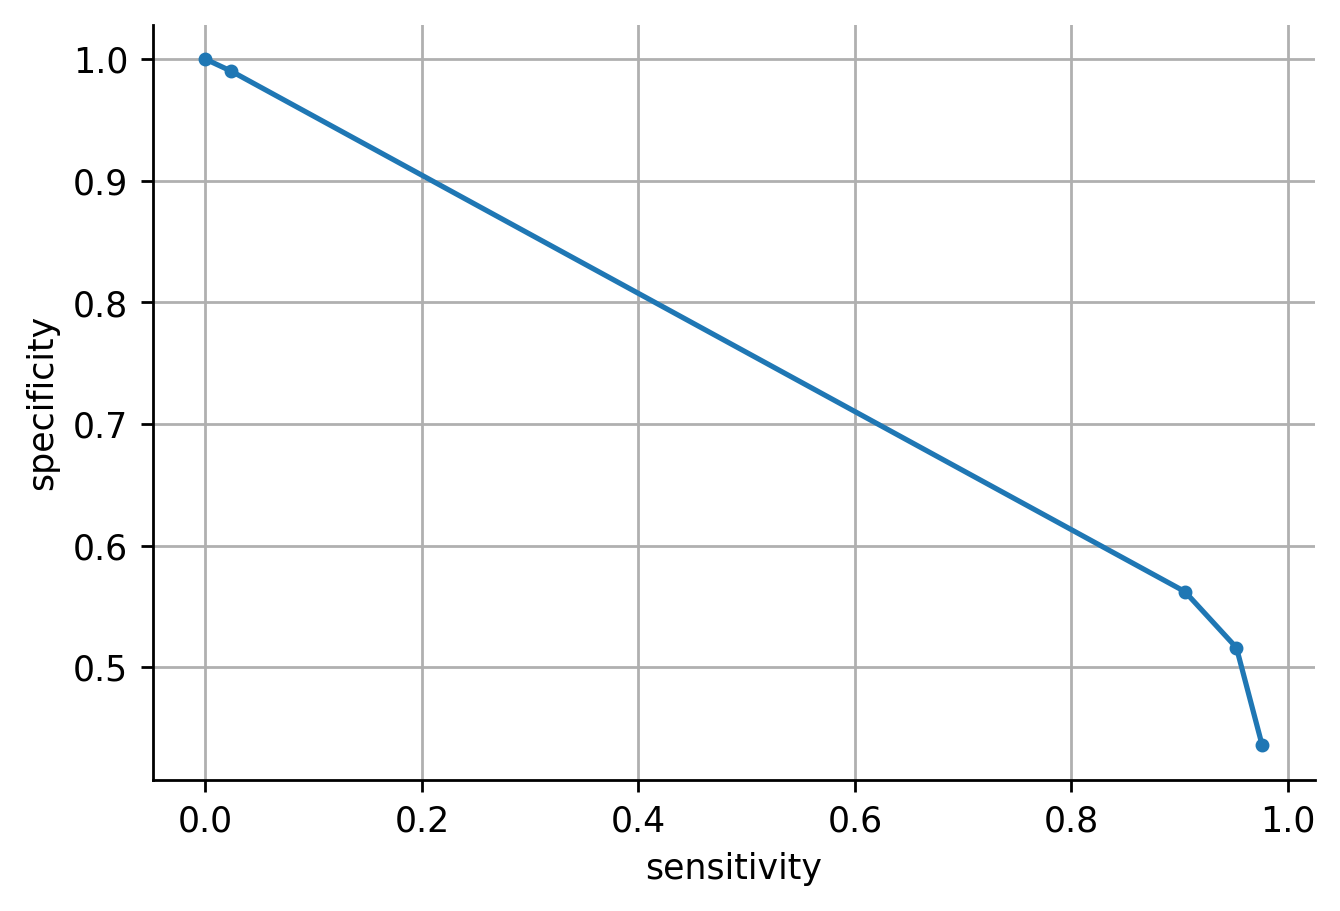

In [109]:
all_stats_curve(y_test, preds, plot=True)